# Tarea 2
# Análisis Inteligente de Datos

### Integrantes

- Sebastián Aedo
- Diego Córdova

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score      
from sklearn.metrics import precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.sandbox.tools.tools_pca import pcasvd

import seaborn as sns
%matplotlib inline

In [2]:
# Diabetes Dataset

vector=['TP','glucose','DBP','TSFT','insulin','mass','DPF','age','status']
diabetes = read_csv('data/pima-indians-diabetes.data',sep=',',names=vector,header=None)

# Hepatitis

A continuación se analizará el dataset de la hepatitis.

Dentro de este dataset se presentan principalmente valores booleanos, 
y la bilirrubina que parece ser una variable contínua, sin embargo,
en la descripción del dataset describen que es un valor **con lazos**, por lo que se podía 
**discretizar**. El objetivo de esta clasificación será intentar predecir la clase a partir
de los otros parámetros.

In [3]:
vector = ["Class", "AGE", "SEX", "STEROID", "ANTIVIRALS", 
          "FATIGUE", "MALAISE", "ANOREXIA", "LIVER BIG", "LIVER FIRM", "SPLEEN PALPABLE",
          "SPIDERS", "ASCITES", "VARICES", "BILIRUBIN", "ALK PHOSPHATE", "SGOT", "ALBUMIN",
          "PROTIME", "HISTOLOGY"]
hepatitis = read_csv('data/hepatitis.data', sep=',', names=vector, header=None)

In [4]:
hepatitis.info()
hepatitis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
Class              155 non-null int64
AGE                155 non-null int64
SEX                155 non-null int64
STEROID            155 non-null object
ANTIVIRALS         155 non-null int64
FATIGUE            155 non-null object
MALAISE            155 non-null object
ANOREXIA           155 non-null object
LIVER BIG          155 non-null object
LIVER FIRM         155 non-null object
SPLEEN PALPABLE    155 non-null object
SPIDERS            155 non-null object
ASCITES            155 non-null object
VARICES            155 non-null object
BILIRUBIN          155 non-null object
ALK PHOSPHATE      155 non-null object
SGOT               155 non-null object
ALBUMIN            155 non-null object
PROTIME            155 non-null object
HISTOLOGY          155 non-null int64
dtypes: int64(5), object(15)
memory usage: 24.3+ KB


,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,2,30,2,1,2,2,2,2,1,2,2,2,2,2,1.00,85,18,4.0,?,1
1,2,50,1,1,2,1,2,2,1,2,2,2,2,2,0.90,135,42,3.5,?,1
2,2,78,1,2,2,1,2,2,2,2,2,2,2,2,0.70,96,32,4.0,?,1
3,2,31,1,?,1,2,2,2,2,2,2,2,2,2,0.70,46,52,4.0,80,1
4,2,34,1,2,2,2,2,2,2,2,2,2,2,2,1.00,?,200,4.0,?,1


## Preparando el dataset

Se puede notar que los valores están como `1`, `2` ó `?`. Para manejarlo con mayor facilidad, se reemplazarán por `True`, `False` o `None` según corresponda.

In [5]:
boolean_columns = ["STEROID", "ANTIVIRALS", "FATIGUE", "MALAISE", "ANOREXIA", "LIVER BIG", "LIVER FIRM", "SPLEEN PALPABLE",
     "SPIDERS", "ASCITES", "VARICES", 'HISTOLOGY']
for column in boolean_columns:
    type_data = {'1': False, '2': True, '?': None}
    hepatitis[column] = hepatitis[column].apply(lambda x: type_data[str(x)])

El Sexo se tratará como `M` ó `F`.

In [6]:
type_data = {'1': 'M', '2': 'F', '?': np.nan}
hepatitis['SEX'] = hepatitis['SEX'].apply(lambda x: type_data[str(x)])

In [7]:
type_data = {'1': 'Dead', '2': 'Alive', '?': None}
hepatitis['Class'] = hepatitis['Class'].apply(lambda x: type_data[str(x)])

Ahora se modificarán las otras variables reemplazando el `?` por `None`.

In [8]:
floats = ['BILIRUBIN', 'ALBUMIN']
integers = ['ALK PHOSPHATE', 'SGOT', 'PROTIME']

for column in floats:
    hepatitis[column] = pd.to_numeric(hepatitis[column], errors='coerce')
    
for column in integers:
    hepatitis[column] = pd.to_numeric(hepatitis[column], errors='coerce')

In [9]:
hepatitis.head()

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,Alive,30,F,False,True,True,True,True,False,True,True,True,True,True,1.0,85.0,18.0,4.0,NaN,False
1,Alive,50,M,False,True,False,True,True,False,True,True,True,True,True,0.9,135.0,42.0,3.5,NaN,False
2,Alive,78,M,True,True,False,True,True,True,True,True,True,True,True,0.7,96.0,32.0,4.0,NaN,False
3,Alive,31,M,None,False,True,True,True,True,True,True,True,True,True,0.7,46.0,52.0,4.0,80.0,False
4,Alive,34,M,True,True,True,True,True,True,True,True,True,True,True,1.0,NaN,200.0,4.0,NaN,False


In [10]:
hepatitis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
Class              155 non-null object
AGE                155 non-null int64
SEX                155 non-null object
STEROID            154 non-null object
ANTIVIRALS         155 non-null bool
FATIGUE            154 non-null object
MALAISE            154 non-null object
ANOREXIA           154 non-null object
LIVER BIG          145 non-null object
LIVER FIRM         144 non-null object
SPLEEN PALPABLE    150 non-null object
SPIDERS            150 non-null object
ASCITES            150 non-null object
VARICES            150 non-null object
BILIRUBIN          149 non-null float64
ALK PHOSPHATE      126 non-null float64
SGOT               151 non-null float64
ALBUMIN            139 non-null float64
PROTIME            88 non-null float64
HISTOLOGY          155 non-null bool
dtypes: bool(2), float64(5), int64(1), object(12)
memory usage: 22.2+ KB


Para analizar un poco más detenidamente, se hará un pairplot con las columnas no booleanas

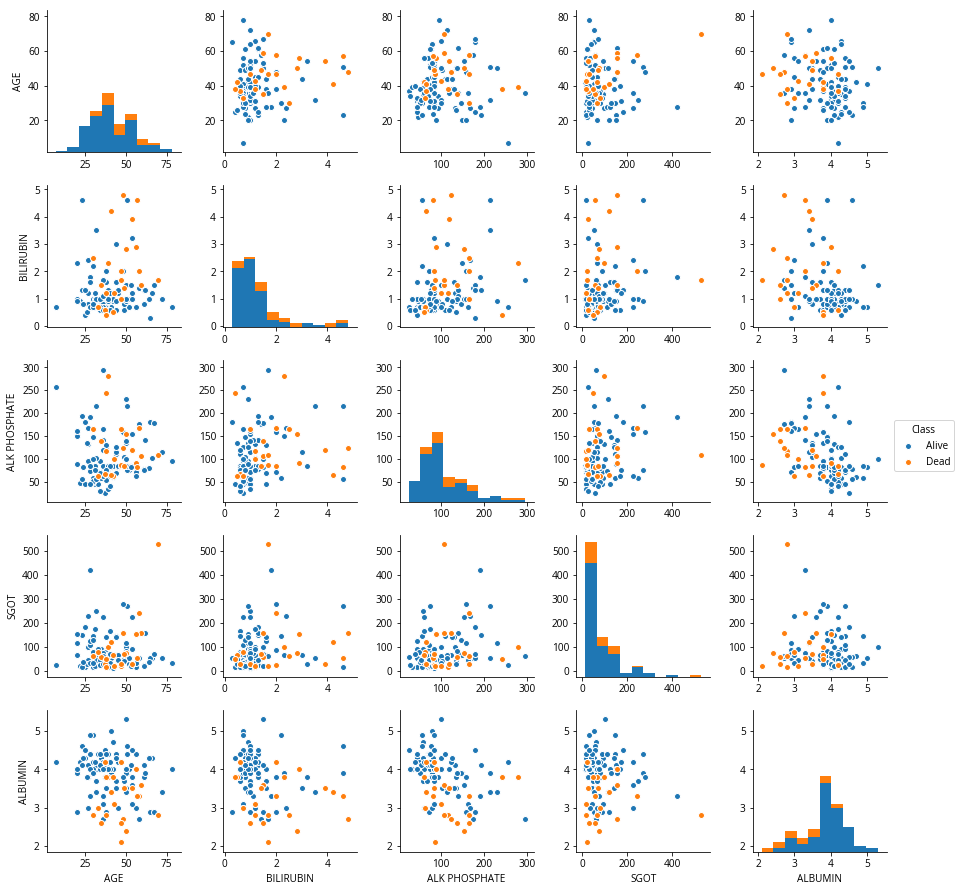

In [11]:
non_boolean = ['Class', 'AGE', 'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN']
without_na = hepatitis.loc[:, non_boolean].dropna()
sns.pairplot(without_na, hue='Class')